# FACIAL RECOGNITION MODEL - GENDER CLASSIFICATION

## DATA IMPORT

In [1]:
import os
import time
import numpy as np
import pandas as pd
import torch
import shutil
import torchvision
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from skimage import io
from PIL import Image
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision import datasets, models, transforms
from torchvision.models import resnet50
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split


In [183]:
# adjust the data path based on your root.
data_path='.'

In [186]:
# get the list of images
images_list = os.listdir(data_path + '/Images/')

# get the list of image labels
attributes = data_path + '/list_attribute.txt'
names = data_path + '/class_identity.txt'

In [187]:
# Check Data, it is a txt table separated by varying length empty spaces
try:
    df = pd.read_csv(attributes, sep='\s+', on_bad_lines='warn')
except pd.errors.ParserError as e:
    print(f"Error: {e}")

<>:3: SyntaxWarning: invalid escape sequence '\s'
<>:3: SyntaxWarning: invalid escape sequence '\s'
C:\Users\azerr\AppData\Local\Temp\ipykernel_24720\63645582.py:3: SyntaxWarning: invalid escape sequence '\s'
  df = pd.read_csv(attributes, sep='\s+', on_bad_lines='warn')


In [188]:
# Check Data
df.describe()

In [6]:
# Check for any na values
df.isna().sum()

202599                 0
5_o_Clock_Shadow       0
Arched_Eyebrows        0
Attractive             0
Bags_Under_Eyes        0
Bald                   0
Bangs                  0
Big_Lips               0
Big_Nose               0
Black_Hair             0
Blond_Hair             0
Blurry                 0
Brown_Hair             0
Bushy_Eyebrows         0
Chubby                 0
Double_Chin            0
Eyeglasses             0
Goatee                 0
Gray_Hair              0
Heavy_Makeup           0
High_Cheekbones        0
Male                   0
Mouth_Slightly_Open    0
Mustache               0
Narrow_Eyes            0
No_Beard               0
Oval_Face              0
Pale_Skin              0
Pointy_Nose            0
Receding_Hairline      0
Rosy_Cheeks            0
Sideburns              0
Smiling                0
Straight_Hair          0
Wavy_Hair              0
Wearing_Earrings       0
Wearing_Hat            0
Wearing_Lipstick       0
Wearing_Necklace       0
Wearing_Necktie        0


### DATA PREP AND CLEANING

In [189]:
'''
# Create directories for the different dataset:
# clean = Image after filtering for duplicates
# the other folder  refers to type_gender, so test / train / val and male / female
'''
clean = data_path + '/clean/'
test_male = data_path + '/test/male'
test_female = data_path + '/test/female'
train_male = data_path + '/train/male'
train_female = data_path + '/train/female'
val_male = data_path + '/val/male'
val_female = data_path + '/val/female'

In [9]:
# Create the direcetory
os.makedirs(clean, exist_ok=True)
os.makedirs(test_male, exist_ok=True)
os.makedirs(test_female, exist_ok=True)
os.makedirs(train_male, exist_ok =True)
os.makedirs(train_female, exist_ok=True)
os.makedirs(val_male, exist_ok =True)
os.makedirs(val_female, exist_ok=True)

In [8]:
# this loop removes duplicate images from the initial dataset to the clean folder

for image in images_list:
    try:
        # Find the image's male value
        gender = df.loc[df['202599'] == image, 'Male'].values[0]
        src_path = os.path.join(data_path + '/Images/' + image)

        # and copy the image to the clean folder.
        shutil.copy(src_path, clean)
    except IndexError:
        # print an error if the image cannot be found in the data table
        print(f"Image {image} not found in the DataFrame.")
    except Exception as e:
        print(f"An error occurred: {e}")

print("Files copied successfully.")

Image 182793(1).jpg not found in the DataFrame.
Image 182809(1).jpg not found in the DataFrame.
Image 182912(1).jpg not found in the DataFrame.
Image 182943(1).jpg not found in the DataFrame.
Image 183005(1).jpg not found in the DataFrame.
Image 183018(1).jpg not found in the DataFrame.
Image 183050(1).jpg not found in the DataFrame.
Image 183111(1).jpg not found in the DataFrame.
Image 183121(1).jpg not found in the DataFrame.
Image 183145(1).jpg not found in the DataFrame.
Image 189132(1).jpg not found in the DataFrame.
Image 189297(1).jpg not found in the DataFrame.
Image 189324(1).jpg not found in the DataFrame.
Image 189512(1).jpg not found in the DataFrame.
Image 189513(1).jpg not found in the DataFrame.
Image 189581(1).jpg not found in the DataFrame.
Image 189651(1).jpg not found in the DataFrame.
Files copied successfully.


In [9]:
# list all the images  in clean
clean_images = os.listdir(clean)

In [10]:
# Split the images into Train, Test, Val, 60:20:20

# Split images to 60:40
train_images, temp_images = train_test_split(clean_images, test_size=0.4, random_state=42)

# Split the remaining 40 into 50:50
test_images, val_images = train_test_split(temp_images, test_size=0.5, random_state=42)

In [190]:
# Move the split images to their respective folders

def move_images( image_list, target):
    try:
        if target in ['test','train','val']:
            for image in image_list:
                gender = df.loc[df['202599'] == image, 'Male'].values[0]
                src_path = os.path.join(data_path + '/clean/' + image)
                if gender == 1:
                    shutil.copy(src_path, data_path + f'/{target}/' + 'male')
                elif gender == -1:
                    shutil.copy(src_path, data_path + f'/{target}/' + 'female')
    except IndexError:
        print(f"Image {image} not found in the DataFrame.")
    except Exception as e:
        print(f"An error occurred: {e}")
print("Files copied successfully.")

Files copied successfully.


In [19]:
# Execute the command to move image
move_images(train_images,'train')
move_images(test_images,'test')
move_images(val_images,'val')

NameError: name 'move_images' is not defined

### DATA AUGMENTATION

In [ ]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(512),
        transforms.RandomRotation(45),
        transforms.RandomResizedCrop(299),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(512),
        transforms.CenterCrop(299),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
     'val': transforms.Compose([
        transforms.Resize(512),
        transforms.CenterCrop(299),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

image_datasets = {x: datasets.ImageFolder(os.path.join(data_path + '/', x),data_transforms[x]) for x in ['train', 'test','val']}

## MODEL CREATION AND TRAINING

### FUNCTIONS

In [283]:
def train_model(name,model, criterion, optimizer, num_epochs=10):
    since = time.time()

    best_model_wts = model.state_dict()
    best_acc = 0.0

    for epoch in range(num_epochs):

        # The prints are commented for convenience in bayesian optimization to prevent log spam
        
        print('Epoch {}/{}'.format(epoch +1, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                #scheduler.step()
                model.train(True)  # Set model to training mode
            else:
                model.train(False)  # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for data in dataloaders[phase]:
                # get the inputs
                inputs, labels = data

                # wrap them in Variable
                if use_gpu:
                    inputs = Variable(inputs.cuda())
                    labels = Variable(labels.cuda())
                else:
                    inputs, labels = Variable(inputs), Variable(labels)

                # zero the parameter gradients
                optimizer.zero_grad()
                # forward
                outputs = model(inputs)
                
                # backward + optimize only if in training phase
                if phase == 'train':
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    loss.backward()
                    optimizer.step()
                else:
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                # statistics
                running_loss += loss.data
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.float() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()
                state = {'model':model.state_dict(),'optim':optimizer.state_dict()}
                torch.save(state,f'./point_{name}_{epoch}_{batch_size}_{learning_rate}_best.pth')

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best test Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [265]:
def train_modelv3(name,model, criterion, optimizer, num_epochs=10):
    since = time.time()

    best_model_wts = model.state_dict()
    best_acc = 0.0

    for epoch in range(num_epochs):

       # The prints are commented for convenience in bayesian optimization to prevent log spam
        
        print('Epoch {}/{}'.format(epoch +1, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                #scheduler.step()
                model.train(True)  # Set model to training mode
            else:
                model.train(False)  # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for data in dataloaders[phase]:
                # get the inputs
                inputs, labels = data

                # wrap them in Variable
                if use_gpu:
                    inputs = Variable(inputs.cuda())
                    labels = Variable(labels.cuda())
                else:
                    inputs, labels = Variable(inputs), Variable(labels)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                outputs = model(inputs)
                
                # backward + optimize only if in training phase
                if phase == 'train':
                    _, preds = torch.max(outputs.logits, 1)
                    loss = criterion(outputs.logits, labels)
                    loss.backward()
                    optimizer.step()
                else:
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                # statistics
                running_loss += loss.data
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.float() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()
                state = {'model':model.state_dict(),'optim':optimizer.state_dict()}
                # torch.save(state,f'./point_{name}_{num_epoch}_{batch_size}_{learning_rate}_best.pth')

        # print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [56]:
def test_model(model,criterion):
    since = time.time()
    model.eval()
    running_corrects = 0
    running_loss = 0.0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for data in dataloaders['test']:
            inputs, labels = data
            if use_gpu:
                inputs = inputs.cuda()
                labels = labels.cuda()
            else:
                inputs, labels = inputs, labels

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            running_loss += loss.data
            running_corrects += torch.sum(preds == labels.data)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    f1 = f1_score(all_labels, all_preds, average='weighted')
    
    test_loss = running_loss / dataset_sizes['test']
    test_acc = running_corrects.float() / dataset_sizes['test']
    time_elapsed = (time.time() - since) / 1000
    print(time_elapsed)
    
    print('Test complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Test Loss: {:.4f} Acc: {:.4f}'.format(test_loss, test_acc))
    print('Precision: {:.4f} Recall: {:.4f} F1 Score: {:.4f}'.format(precision, recall, f1))

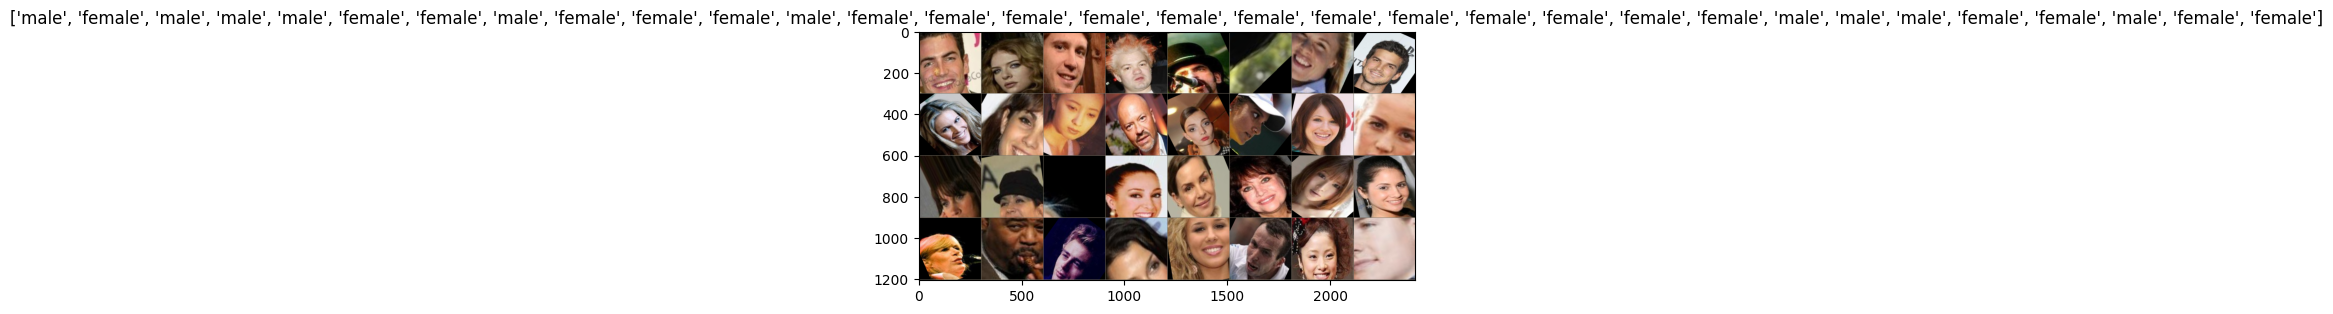

In [159]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

### HYPERPARAMETER DEFINITION

In [284]:
# Defining the loss criterion and hyperparameter

criterion = nn.CrossEntropyLoss()
epoch = 45
learning_rate = 0.083
batch_size = 16

In [285]:
# dataloaders and dataset images are created here, because it is affected by hyperparameter batch size
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size,shuffle=True, num_workers=4) for x in ['train', 'test','val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test','val']}
class_names = image_datasets['train'].classes

use_gpu = torch.cuda.is_available()

### MODEL TRAINING

In [143]:
from torchvision.models.googlenet import googlenet
from sklearn.metrics import precision_score, recall_score, f1_score

In [286]:
# Import the model to be tested
model = googlenet(pretrained=True)


optimizer = optim.SGD(model.parameters(), lr=learning_rate)

# We are changing the fully connected from 1024 to 2
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2) # MALE OR FEMALE
if use_gpu:                                 
    model = model.cuda() 

In [287]:
model = train_model('googlenetv1',model, criterion,optimizer,epoch)

Epoch 1/45
----------
train Loss: 0.0261 Acc: 0.8063
val Loss: 0.0188 Acc: 0.8590

Epoch 2/45
----------
train Loss: 0.0184 Acc: 0.8700
val Loss: 0.0152 Acc: 0.8870

Epoch 3/45
----------
train Loss: 0.0171 Acc: 0.8830
val Loss: 0.0565 Acc: 0.6940

Epoch 4/45
----------
train Loss: 0.0155 Acc: 0.8910
val Loss: 0.0086 Acc: 0.9470

Epoch 5/45
----------
train Loss: 0.0132 Acc: 0.9090
val Loss: 0.0101 Acc: 0.9330

Epoch 6/45
----------
train Loss: 0.0124 Acc: 0.9167
val Loss: 0.0093 Acc: 0.9410

Epoch 7/45
----------
train Loss: 0.0123 Acc: 0.9170
val Loss: 0.0087 Acc: 0.9340

Epoch 8/45
----------
train Loss: 0.0124 Acc: 0.9163
val Loss: 0.0098 Acc: 0.9270

Epoch 9/45
----------
train Loss: 0.0116 Acc: 0.9253
val Loss: 0.0071 Acc: 0.9550

Epoch 10/45
----------
train Loss: 0.0107 Acc: 0.9313
val Loss: 0.0068 Acc: 0.9630

Epoch 11/45
----------
train Loss: 0.0111 Acc: 0.9223
val Loss: 0.0063 Acc: 0.9650

Epoch 12/45
----------
train Loss: 0.0100 Acc: 0.9357
val Loss: 0.0068 Acc: 0.9510

E

In [288]:
test_model(model,criterion)

0.0033757476806640626
Test complete in 0m 0s
Test Loss: 0.0088 Acc: 0.9640
Precision: 0.9649 Recall: 0.9640 F1 Score: 0.9641


In [266]:
model_v3 = models.inception_v3(pretrained=True)

In [267]:
optimizer = optim.SGD(model_v3.parameters(), lr=learning_rate)
num_ftrs = model_v3.fc.in_features
model_v3.fc = nn.Linear(num_ftrs, 2) # MALE OR FEMALE
if use_gpu:                                 
    model_v3 = model_v3.cuda() 

In [268]:
model = train_modelv3('googlenetv3',model_v3,criterion,optimizer,num_epochs=20)

Epoch 1/20
----------
train Loss: 0.0189 Acc: 0.6663
val Loss: 0.0137 Acc: 0.8590
Epoch 2/20
----------
train Loss: 0.0123 Acc: 0.8360
val Loss: 0.0092 Acc: 0.8900
Epoch 3/20
----------
train Loss: 0.0098 Acc: 0.8663
val Loss: 0.0103 Acc: 0.8360
Epoch 4/20
----------
train Loss: 0.0083 Acc: 0.8843
val Loss: 0.0055 Acc: 0.9420
Epoch 5/20
----------
train Loss: 0.0076 Acc: 0.8967
val Loss: 0.0062 Acc: 0.9330
Epoch 6/20
----------
train Loss: 0.0066 Acc: 0.9143
val Loss: 0.0051 Acc: 0.9370
Epoch 7/20
----------
train Loss: 0.0069 Acc: 0.9047
val Loss: 0.0058 Acc: 0.9140
Epoch 8/20
----------
train Loss: 0.0059 Acc: 0.9180
val Loss: 0.0046 Acc: 0.9360
Epoch 9/20
----------
train Loss: 0.0056 Acc: 0.9247
val Loss: 0.0041 Acc: 0.9500
Epoch 10/20
----------
train Loss: 0.0050 Acc: 0.9323
val Loss: 0.0036 Acc: 0.9600
Epoch 11/20
----------
train Loss: 0.0052 Acc: 0.9307
val Loss: 0.0036 Acc: 0.9570
Epoch 12/20
----------
train Loss: 0.0050 Acc: 0.9343
val Loss: 0.0032 Acc: 0.9660
Epoch 13/20
-

In [269]:
test_model(model_v3,criterion)

0.003868277311325073
Test complete in 0m 0s
Test Loss: 0.0030 Acc: 0.9640
Precision: 0.9645 Recall: 0.9640 F1 Score: 0.9641


In [161]:
from sklearn.model_selection import GridSearchCV, ParameterGrid

## HYPERPARAMETER TUNING

### GRID SEARCH

In [201]:
def evaluate_model(model, dataloader):
    model.eval()
    running_corrects = 0
    
    with torch.no_grad():
        for inputs, labels in dataloader:
            if use_gpu:
                inputs = inputs.cuda()
                labels = labels.cuda()
                
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            running_corrects += torch.sum(preds == labels.data)
    
    accuracy = running_corrects.double() / len(dataloader.dataset)
    return accuracy

In [202]:
param_grid = {
    'num_epochs': [10,20,50],
    'learning_rate': [0.001, 0.01, 0.1],
    'batch_size': [8,16,32],
}


In [203]:
best_params = None
best_score = 0.0

In [205]:
best_model = models.inception_v3(pretrained=True)
best_dict = None

for params in ParameterGrid(param_grid):
    dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=params['batch_size'],shuffle=True, num_workers=4) for x in ['train', 'test','val']}
    model = models.inception_v3(pretrained=True)
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, 2) # MALE OR FEMALE
    if use_gpu:                                 
        model = model.cuda() 
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=params['learning_rate'])

    # Ensure the correct model training function is called
    
    model = train_modelv3('grid_search', model, criterion, optimizer, params['num_epochs'])
    accuracy = evaluate_model(model, dataloaders['val'])
    
    if accuracy > best_score:
        best_score = accuracy
        best_params = params
        best_dict = model.state_dict()

print("Best parameters found: ", best_params)
print("Best accuracy found: ", best_score)

Epoch 1/10
----------
train Loss: 0.0790 Acc: 0.6347
val Loss: 0.0671 Acc: 0.6900

Epoch 2/10
----------
train Loss: 0.0644 Acc: 0.7493
val Loss: 0.0513 Acc: 0.8650

Epoch 3/10
----------
train Loss: 0.0561 Acc: 0.7897
val Loss: 0.0430 Acc: 0.8720

Epoch 4/10
----------
train Loss: 0.0491 Acc: 0.8173
val Loss: 0.0383 Acc: 0.8840

Epoch 5/10
----------
train Loss: 0.0470 Acc: 0.8267
val Loss: 0.0317 Acc: 0.8920

Epoch 6/10
----------
train Loss: 0.0435 Acc: 0.8353
val Loss: 0.0310 Acc: 0.9000

Epoch 7/10
----------
train Loss: 0.0428 Acc: 0.8413
val Loss: 0.0279 Acc: 0.9200

Epoch 8/10
----------
train Loss: 0.0411 Acc: 0.8470
val Loss: 0.0269 Acc: 0.9210

Epoch 9/10
----------
train Loss: 0.0394 Acc: 0.8593
val Loss: 0.0245 Acc: 0.9220

Epoch 10/10
----------
train Loss: 0.0366 Acc: 0.8743
val Loss: 0.0220 Acc: 0.9290

Training complete in 3m 51s
Best val Acc: 0.929000
Epoch 1/20
----------
train Loss: 0.0795 Acc: 0.6347
val Loss: 0.0662 Acc: 0.7180

Epoch 2/20
----------
train Loss: 0

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x000002BB97DCC900>
Traceback (most recent call last):
  File "C:\Users\azerr\ai\Lib\site-packages\torch\utils\data\dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "C:\Users\azerr\ai\Lib\site-packages\torch\utils\data\dataloader.py", line 1437, in _shutdown_workers
    if self._persistent_workers or self._workers_status[worker_id]:
                                   ^^^^^^^^^^^^^^^^^^^^
AttributeError: '_MultiProcessingDataLoaderIter' object has no attribute '_workers_status'


Epoch 1/20
----------
train Loss: 0.0596 Acc: 0.7520
val Loss: 0.0409 Acc: 0.8480

Epoch 2/20
----------
train Loss: 0.0472 Acc: 0.8220
val Loss: 0.0219 Acc: 0.9320

Epoch 3/20
----------
train Loss: 0.0401 Acc: 0.8637
val Loss: 0.0319 Acc: 0.8790

Epoch 4/20
----------
train Loss: 0.0332 Acc: 0.8800
val Loss: 0.0281 Acc: 0.8990

Epoch 5/20
----------
train Loss: 0.0320 Acc: 0.8900
val Loss: 0.0155 Acc: 0.9570

Epoch 6/20
----------
train Loss: 0.0275 Acc: 0.8983
val Loss: 0.0167 Acc: 0.9490

Epoch 7/20
----------
train Loss: 0.0282 Acc: 0.9043
val Loss: 0.0138 Acc: 0.9590

Epoch 8/20
----------
train Loss: 0.0267 Acc: 0.9113
val Loss: 0.0121 Acc: 0.9630

Epoch 9/20
----------
train Loss: 0.0290 Acc: 0.9143
val Loss: 0.0185 Acc: 0.9550

Epoch 10/20
----------
train Loss: 0.0228 Acc: 0.9307
val Loss: 0.0142 Acc: 0.9510

Epoch 11/20
----------
train Loss: 0.0258 Acc: 0.9150
val Loss: 0.0107 Acc: 0.9690

Epoch 12/20
----------
train Loss: 0.0234 Acc: 0.9240
val Loss: 0.0138 Acc: 0.9600

E

### BAYESIAN OPTIMIZATION

In [270]:
from bayes_opt import BayesianOptimization

In [271]:
pbounds = {
    'num_epoch': (10,50),
    'learning_rate': (0.001,0.1),
    'batch_size': (8,32)
}

In [275]:
def create_model(learning_rate,batch_size):

    # make sure the model version is right
    
    model = models.googlenet(pretrained=True)
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, 2) # MALE OR FEMALE
    if use_gpu:                                 
        model = model.cuda() 
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=params['learning_rate'])
    return (
        model,
        criterion,
        optimizer
    )

In [276]:
def objective(learning_rate,batch_size,num_epoch):
    dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=int(batch_size),shuffle=True, num_workers=4) for x in ['train', 'test','val']}
    model,criterion,optimizer = create_model(learning_rate,batch_size)

    # make sure the training function is the correct model's training
    model = train_model('bayesian_optimization', model, criterion, optimizer, int(num_epoch))
    accuracy = evaluate_model(model, dataloaders['val'])
    if isinstance(accuracy, torch.Tensor):
        accuracy = accuracy.item()
        
    return accuracy

In [277]:
optimizer = BayesianOptimization(f=objective, pbounds=pbounds, verbose=2)
optimizer.maximize(init_points=5, n_iter=20)

|   iter    |  target   | batch_... | learni... | num_epoch |
-------------------------------------------------------------


C:\Users\azerr\ai\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\azerr\ai\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)














































| 1         | 0.971     | 16.03     | 0.0154    | 44.6      |





























| 2         | 0.967     | 13.67     | 0.05078   | 29.69     |








































| 3         | 0.967     | 29.88     | 0.08057   | 40.25     |



























| 4         | 0.971     | 27.52     | 0.07746   | 27.63     |

































| 5         | 0.894     | 31.09     | 0.08755   | 33.94     |


C:\Users\azerr\ai\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\azerr\ai\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x000002BB97DCC900>
Traceback (most recent call last):
  File "C:\Users\azerr\ai\Lib\site-packages\torch\utils\data\dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "C:\Users\azerr\ai\Lib\site-packages\torch\utils\data\dataloader.py", line 1437, in _shutdown_workers
    if self._pers


























| 6         | 0.961     | 19.69     | 0.049     | 25.46     |


C:\Users\azerr\ai\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\azerr\ai\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)





























| 7         | 0.967     | 27.49     | 0.07802   | 27.64     |


C:\Users\azerr\ai\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\azerr\ai\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)





























| 8         | 0.973     | 27.92     | 0.09441   | 27.6      |


C:\Users\azerr\ai\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\azerr\ai\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)





























| 9         | 0.96      | 27.56     | 0.006813  | 27.2      |


C:\Users\azerr\ai\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\azerr\ai\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)






























| 10        | 0.957     | 27.95     | 0.0476    | 28.13     |


C:\Users\azerr\ai\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\azerr\ai\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)





























| 11        | 0.971     | 27.56     | 0.01774   | 27.18     |


C:\Users\azerr\ai\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\azerr\ai\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)





















| 12        | 0.944     | 17.09     | 0.0824    | 19.62     |


C:\Users\azerr\ai\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\azerr\ai\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)





























| 13        | 0.941     | 28.0      | 0.02851   | 27.61     |


C:\Users\azerr\ai\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\azerr\ai\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)





























| 14        | 0.969     | 27.62     | 0.04703   | 27.04     |


C:\Users\azerr\ai\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\azerr\ai\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)





























| 15        | 0.967     | 27.66     | 0.02904   | 27.69     |


C:\Users\azerr\ai\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\azerr\ai\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)





























| 16        | 0.969     | 27.46     | 0.06054   | 27.16     |


C:\Users\azerr\ai\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\azerr\ai\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)





























| 17        | 0.968     | 27.87     | 0.0606    | 27.7      |


C:\Users\azerr\ai\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\azerr\ai\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)





























| 18        | 0.968     | 27.66     | 0.02384   | 27.64     |


C:\Users\azerr\ai\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\azerr\ai\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


















































| 19        | 0.96      | 19.64     | 0.07794   | 48.42     |


C:\Users\azerr\ai\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\azerr\ai\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
















| 20        | 0.954     | 29.11     | 0.09965   | 14.72     |


C:\Users\azerr\ai\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\azerr\ai\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)














































| 21        | 0.971     | 15.91     | 0.01175   | 44.59     |


C:\Users\azerr\ai\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\azerr\ai\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)





























| 22        | 0.966     | 27.75     | 0.05317   | 27.53     |


C:\Users\azerr\ai\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\azerr\ai\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)




































| 23        | 0.962     | 13.58     | 0.08317   | 34.76     |


C:\Users\azerr\ai\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\azerr\ai\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)














































| 24        | 0.979     | 15.77     | 0.08368   | 44.65     |


C:\Users\azerr\ai\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\azerr\ai\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)












| 25        | 0.955     | 26.43     | 0.09582   | 10.75     |


In [291]:
result_data = './result.csv'
# Check Data, it is a txt table separated by varying length empty spaces
try:
    df = pd.read_csv(result_data, sep=',', on_bad_lines='warn')
except pd.errors.ParserError as e:
    print(f"Error: {e}")

In [302]:
import seaborn as sns

In [305]:
sns.set(style="whitegrid")
palette = sns.color_palette("husl", len(df['Model'].unique()))

In [314]:
def plot_bars(df, metric, ylabel, title):
    plt.figure(figsize=(12, 6))
    bars = plt.bar(df['Label'], df[metric], color='blue')
    plt.xlabel('Model-Epoch-BatchSize-LearningRate')
    plt.ylabel(ylabel)
    plt.title(title)
    plt.xticks(rotation=45, ha='right')
    
    # Highlight the highest and lowest values
    max_val = df[metric].max()
    min_val = df[metric].min()
    
    for bar, value, label in zip(bars, df[metric], plt.gca().get_xticklabels()):
        if value == max_val:
            bar.set_color('green')
            label.set_color('green')
        elif value == min_val:
            bar.set_color('red')
            label.set_color('red')
    
    plt.show()

In [299]:
df['Label'] = df.apply(lambda row: f"{row['Model']}-{row['Epoch']}-{row['Batch Size']}-{row['Learning Rate']}", axis=1)


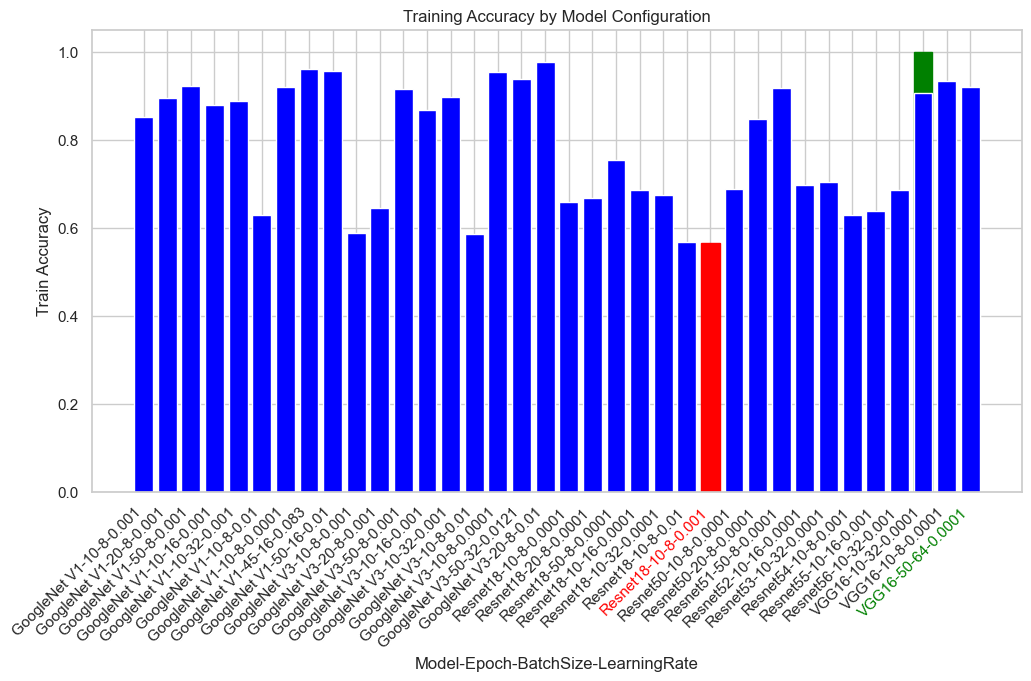

In [315]:
plot_bars(df, 'Train Accuracy', 'Train Accuracy', 'Training Accuracy by Model Configuration')


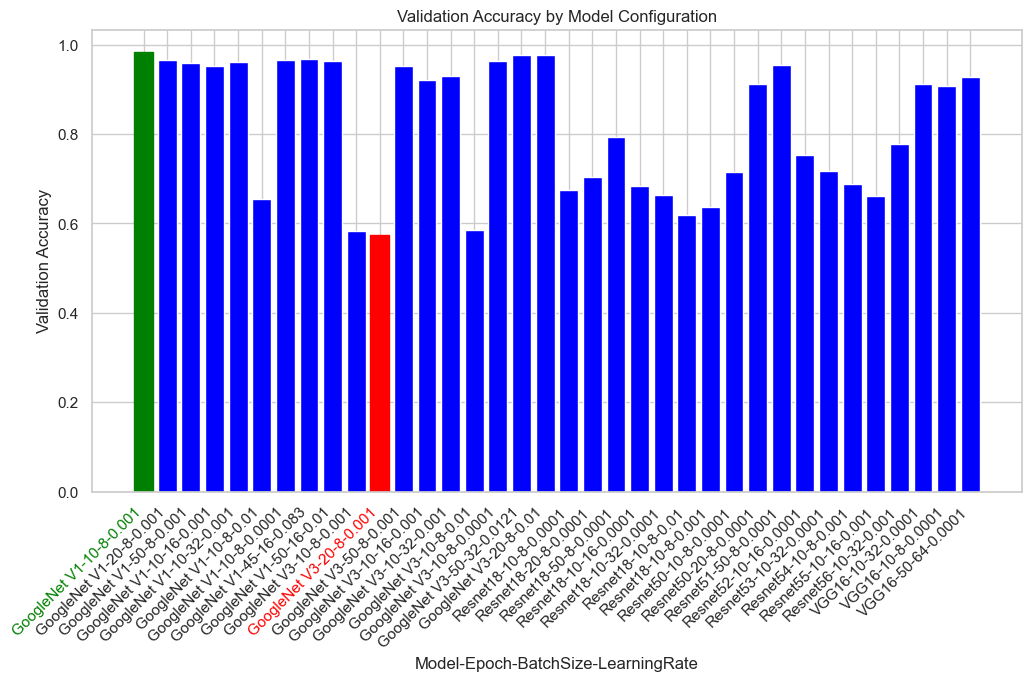

In [316]:
plot_bars(df, 'Val Accuracy', 'Validation Accuracy', 'Validation Accuracy by Model Configuration')

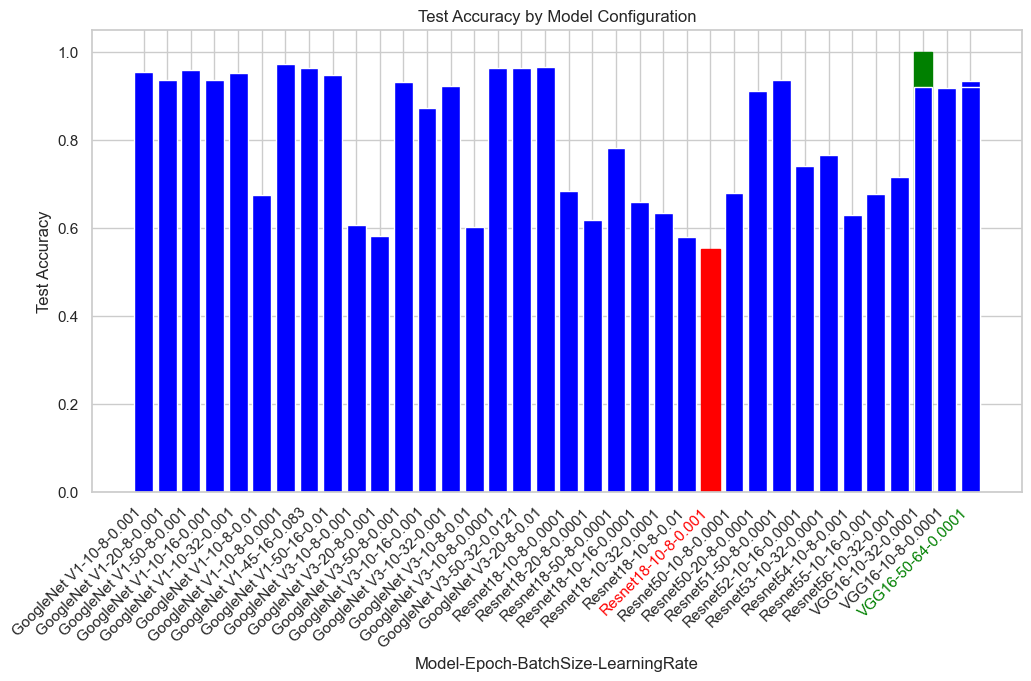

In [317]:
plot_bars(df, 'Test Accuracy', 'Test Accuracy', 'Test Accuracy by Model Configuration')

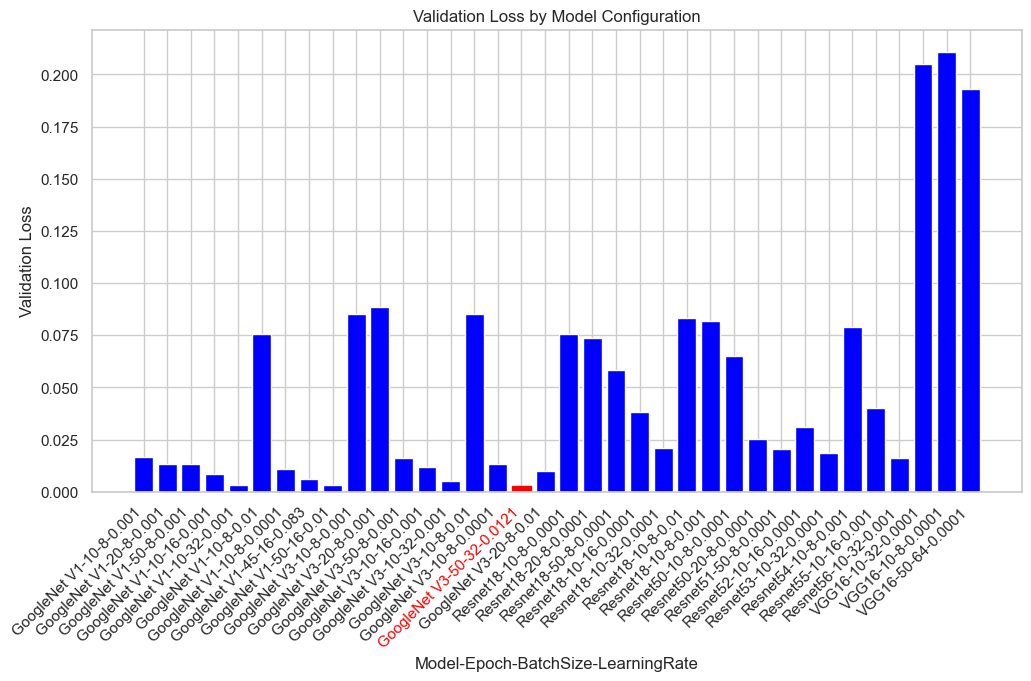

In [318]:
plot_bars(df, 'Val Loss', 'Validation Loss', 'Validation Loss by Model Configuration')

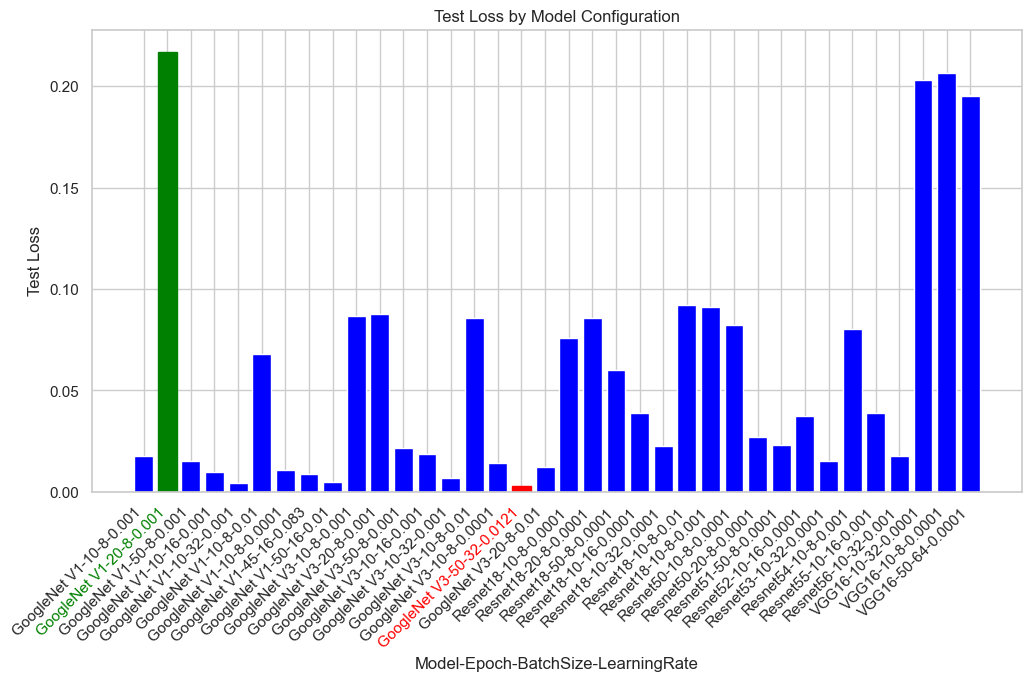

In [319]:
plot_bars(df, 'Test Loss', 'Test Loss', 'Test Loss by Model Configuration')